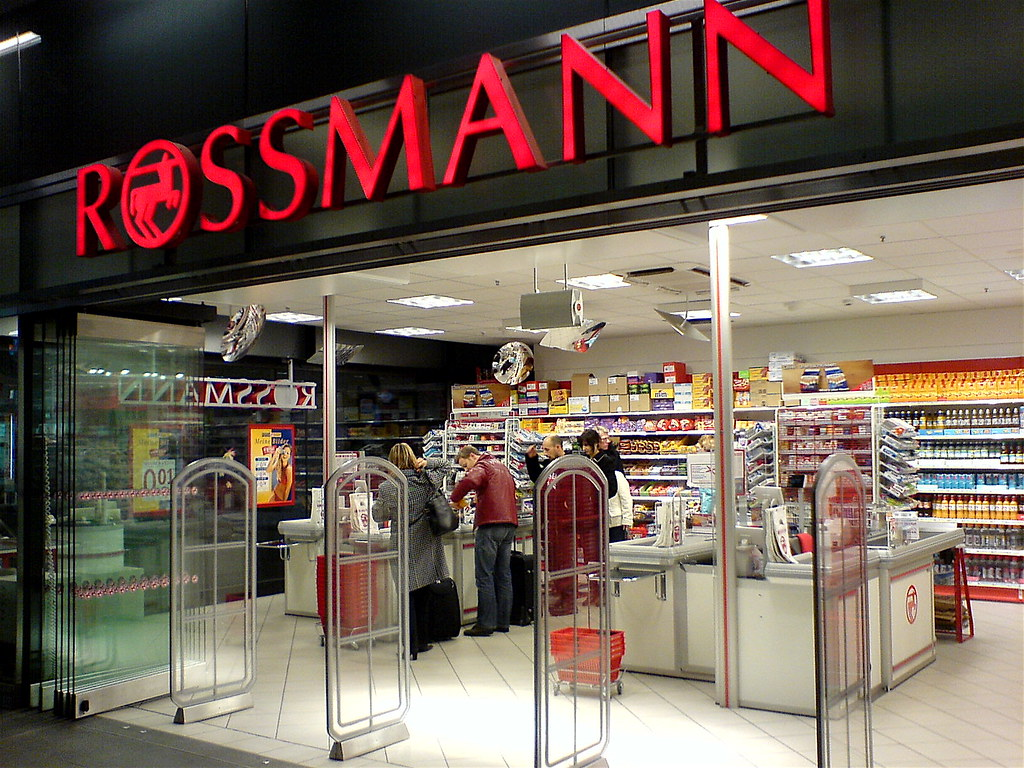

Rossmann is challenging you to predict **6 weeks of daily sales** for **1,115 stores** located across Germany

## Dataset
| Field                        | Description |
|-----------------------------|-------------|
| **Id**                      | An Id that represents a (Store, Date) duple within the test set. |
| **Store**                   | A unique Id for each store. |
| **Sales**                   | The turnover for any given day (this is what you are predicting). |
| **Customers**               | The number of customers on a given day. |
| **Open**                    | Indicator for whether the store was open: `0 = closed`, `1 = open`. |
| **StateHoliday**            | Indicates a state holiday: `a = public holiday`, `b = Easter holiday`, `c = Christmas`, `0 = None`. Most stores are closed on state holidays. |
| **SchoolHoliday**           | Indicates if the (Store, Date) was affected by public school closures. |
| **StoreType**               | Differentiates between 4 different store models: `a`, `b`, `c`, `d`. |
| **Assortment**              | Describes assortment level: `a = basic`, `b = extra`, `c = extended`. pick what product to sell and when |
| **CompetitionDistance**     | Distance in meters to the nearest competitor store. |
| **CompetitionOpenSinceMonth / Year** | Approximate month and year when the nearest competitor was opened. |
| **Promo**                   | Indicates whether a store is running a promo on that day. |
| **Promo2**                  | Indicates if the store is part of a continuous promotion: `0 = not participating`, `1 = participating`. |
| **Promo2SinceYear / Week**  | The year and calendar week when the store started participating in Promo2. |
| **PromoInterval**           | Months when Promo2 promotions start, e.g., `"Feb,May,Aug,Nov"` means rounds start in those months. |

# Libraries

In [143]:
# standard lib
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import sys
import os
sys.path.append(os.path.abspath(".."))


#time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import kpss,adfuller # to test if ts is stationary




#simple 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

#STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import STL


# Arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# prophet by Facebook
from prophet import Prophet

# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 0. Reading the data

In [2]:
df_train = pd.read_csv('../data/train.csv', parse_dates=['Date'],low_memory=False)
df_store = pd.read_csv('../data/store.csv')

df_test = pd.read_csv('../data/test.csv', parse_dates=['Date'])

# 1. EDA

In [3]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [5]:
for col in df_train.columns:
    print(f"*****************{col}**********************")
    print(df_train[col].unique())
    print("*********************************************")
    print(df_train[col].value_counts())

*****************Store**********************
[   1    2    3 ... 1113 1114 1115]
*********************************************
Store
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: count, Length: 1115, dtype: int64
*****************DayOfWeek**********************
[5 4 3 2 1 7 6]
*********************************************
DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64
*****************Date**********************
<DatetimeArray>
['2015-07-31 00:00:00', '2015-07-30 00:00:00', '2015-07-29 00:00:00',
 '2015-07-28 00:00:00', '2015-07-27 00:00:00', '2015-07-26 00:00:00',
 '2015-07-25 00:00:00', '2015-07-24 00:00:00', '2015-07-23 00:00:00',
 '2015-07-22 00:00:00',
 ...
 '2013-01-10 00:00:00', '2013-01-09 00:00:00', '2013-01-08 00:00:00',
 '2013-01-07 00:00:00', '2013-01-06 00:00:00', '2013-01-05 00:00:00',
 '2013-01-04 00:00:00', '2013-01-03 

In [6]:
df_train.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


In [7]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
for col in df_store.columns:
    print(f"*****************{col}**********************")
    print(df_store[col].unique())
    print("*********************************************")
    print(df_store[col].value_counts())

*****************Store**********************
[   1    2    3 ... 1113 1114 1115]
*********************************************
Store
1       1
742     1
748     1
747     1
746     1
       ..
378     1
379     1
380     1
381     1
1115    1
Name: count, Length: 1115, dtype: int64
*****************StoreType**********************
['c' 'a' 'd' 'b']
*********************************************
StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64
*****************Assortment**********************
['a' 'c' 'b']
*********************************************
Assortment
a    593
c    513
b      9
Name: count, dtype: int64
*****************CompetitionDistance**********************
[1.270e+03 5.700e+02 1.413e+04 6.200e+02 2.991e+04 3.100e+02 2.400e+04
 7.520e+03 2.030e+03 3.160e+03 9.600e+02 1.070e+03 1.300e+03 4.110e+03
 3.270e+03 5.000e+01 1.384e+04 3.240e+03 2.340e+03 5.500e+02 1.040e+03
 4.060e+03 4.590e+03 4.300e+02 2.300e+03 6.000e+01 1.200e+03 2.170e+03
 4.000e+01 9.80

In [10]:
df_train['Date'].min(),df_train['Date'].max(),

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [11]:
full_range = pd.date_range(start=df_train.Date.min(), end=df_train.Date.max(), freq='D')  # 'D' = daily frequency
len(full_range)

942

In [12]:
df_train.shape

(1017209, 9)

In [13]:
df_train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [14]:
df_train.duplicated().sum()

0

## Closed but not a holiday

In [15]:
closed_df = df_train[df_train['Open'] == 0]

In [16]:
closed_store_no_holiday= df_train[(df_train["Open"] == 0) &
         (df_train["StateHoliday"] == "0")
         &(df_train["SchoolHoliday"] == 0)]
print(f"Number of times the stores closed without having a holiday: {len(closed_store_no_holiday)}")

Number of times the stores closed without having a holiday: 139610


In [17]:
closed_store_no_holiday.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
5575,1,7,2015-07-26,0,0,0,0,0,0
5576,2,7,2015-07-26,0,0,0,0,0,0
5577,3,7,2015-07-26,0,0,0,0,0,0
5578,4,7,2015-07-26,0,0,0,0,0,0
5579,5,7,2015-07-26,0,0,0,0,0,0


In [18]:
print(f"Percentage of closed stores for refurbishments {(len(closed_store_no_holiday)/len(df_train)*100):.2f}%")

Percentage of closed stores for refurbishments 13.72%


In [19]:
## Open but no sales

open_sales_0 = \
df_train[(df_train["Open"] == 1) &
         (df_train["Sales"] == 0)]
print(f"Number of times the stores Open but no sales: {len(open_sales_0)}")

Number of times the stores Open but no sales: 54


## Few observations:
- It seems our data span a little over two years and a half: need to make sure that there is no missing date/ missing timestamps
- There is no missing timestamps: but our data is gathered to be store-day combinations, meaning each of the 1115 report their sales each day for 942 days.

    1115*942 = 1,050,330 row,

    while our data is 1,017,209 row,

    so we have 33,121 missing combinations.
    making some stores unfit for the analysis

- There are 139610 days closed store with no holiday:

    After reading the descrition of the this task, Rossman clearly stated that they were undergoing refurbishments sometimes and had to close. Most probably those were the times this event was happening.

    This can introduce bias to our models: closed days shouldn't be used for modeling
- the 54 days of open stores with no sales and no customers should't be used for modeling 


## Merge: 
I will not merge store and train as store features in not in test

In [20]:
df_full = pd.merge(df_train, df_store, on='Store', how='left')
df_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Add More Features

In [21]:
df_full['Year'] = df_full['Date'].dt.year.iloc[0]
df_full['Month'] = df_full['Date'].dt.month.iloc[0]
df_full['Day'] = df_full['Date'].dt.day.iloc[0]
df_full['WeekOfYear'] = df_full['Date'].dt.isocalendar().week.iloc[0]

# adding new variable
df_full['SalePerCustomer'] = df_full['Sales']/df_full['Customers']
df_full['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [22]:
df_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,8.626118


In [23]:
df_full.sort_values(["Store", "Date"], inplace=True)


In [24]:
df_full["missing"] = (
    df_full["Sales"].isna() |
    ((df_full["Open"] == 1) & (df_full["Sales"] == 0))|
    ((df_full["Open"] == 0)
    &(df_full["StateHoliday"] == "0")
    &(df_full["SchoolHoliday"] == 0))
)

print(f"Missing rows: {df_full['missing'].sum()} out of {len(df_full)}")


Missing rows: 139664 out of 1017209


In [25]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1016095 to 1114
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 non-

In [26]:
def preprocess_rossmann(df, is_train=True):
    # convert date if not parced already
    df['Date'] = pd.to_datetime(df['Date'])
    
    # extract calendar parts
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    
    # sales per customer
    df['SalePerCustomer'] = df['Sales'] / df['Customers']

    
    # missing flag (used to identify problematic rows)
    df["missing"] = (
        df["Sales"].isna() |
        ((df["Open"] == 1) & (df["Sales"] == 0)) |
        ((df["Open"] == 0) &
         (df["StateHoliday"].astype(str) == "0") &
         (df["SchoolHoliday"] == 0))
        
    )
    # Map StateHoliday from {'a','b','c','0'}
    state_holiday_map = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
    df['StateHoliday'] = df['StateHoliday'].astype(str).map(state_holiday_map).fillna(0).astype(int)
    
    # drop rows with missing flag if training
    if is_train:
        df['Assortment'] = df['Assortment'].astype(str).map(state_holiday_map).fillna(0).astype(int)
        df['StoreType'] = df['StoreType'].astype(str).map(state_holiday_map).fillna(0).astype(int)

        df = df[~df["missing"]].copy()
        df.drop(columns = ['PromoInterval'], inplace = True)
        
    return df
    
    


In [27]:
df_full = preprocess_rossmann(df_full, is_train=True)

In [28]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877545 entries, 1016095 to 1114
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      877545 non-null  int64         
 1   DayOfWeek                  877545 non-null  int64         
 2   Date                       877545 non-null  datetime64[ns]
 3   Sales                      877545 non-null  int64         
 4   Customers                  877545 non-null  int64         
 5   Open                       877545 non-null  int64         
 6   Promo                      877545 non-null  int64         
 7   StateHoliday               877545 non-null  int32         
 8   SchoolHoliday              877545 non-null  int64         
 9   StoreType                  877545 non-null  int32         
 10  Assortment                 877545 non-null  int32         
 11  CompetitionDistance        875278 non-null  float64  

In [29]:
df_full.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,SalePerCustomer,missing
1016095,1,2,2013-01-01,0,0,0,0,1,1,3,...,2008.0,0,NaN,NaN,2013,1,1,1,NaN,False
1014980,1,3,2013-01-02,5530,668,1,0,0,1,3,...,2008.0,0,NaN,NaN,2013,1,2,1,8.278443,False
1013865,1,4,2013-01-03,4327,578,1,0,0,1,3,...,2008.0,0,NaN,NaN,2013,1,3,1,7.486159,False
1012750,1,5,2013-01-04,4486,619,1,0,0,1,3,...,2008.0,0,NaN,NaN,2013,1,4,1,7.247173,False
1011635,1,6,2013-01-05,4997,635,1,0,0,1,3,...,2008.0,0,NaN,NaN,2013,1,5,1,7.869291,False


## Visualization

(array([144423., 145432.,      0., 145442.,      0., 145612., 145644.,
             0., 144450.,   6542.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

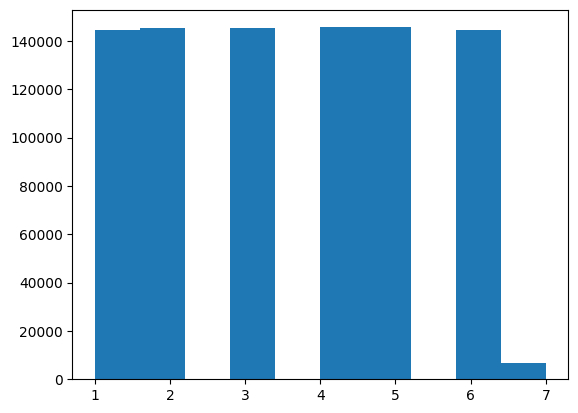

In [30]:
plt.hist(df_full['DayOfWeek'])

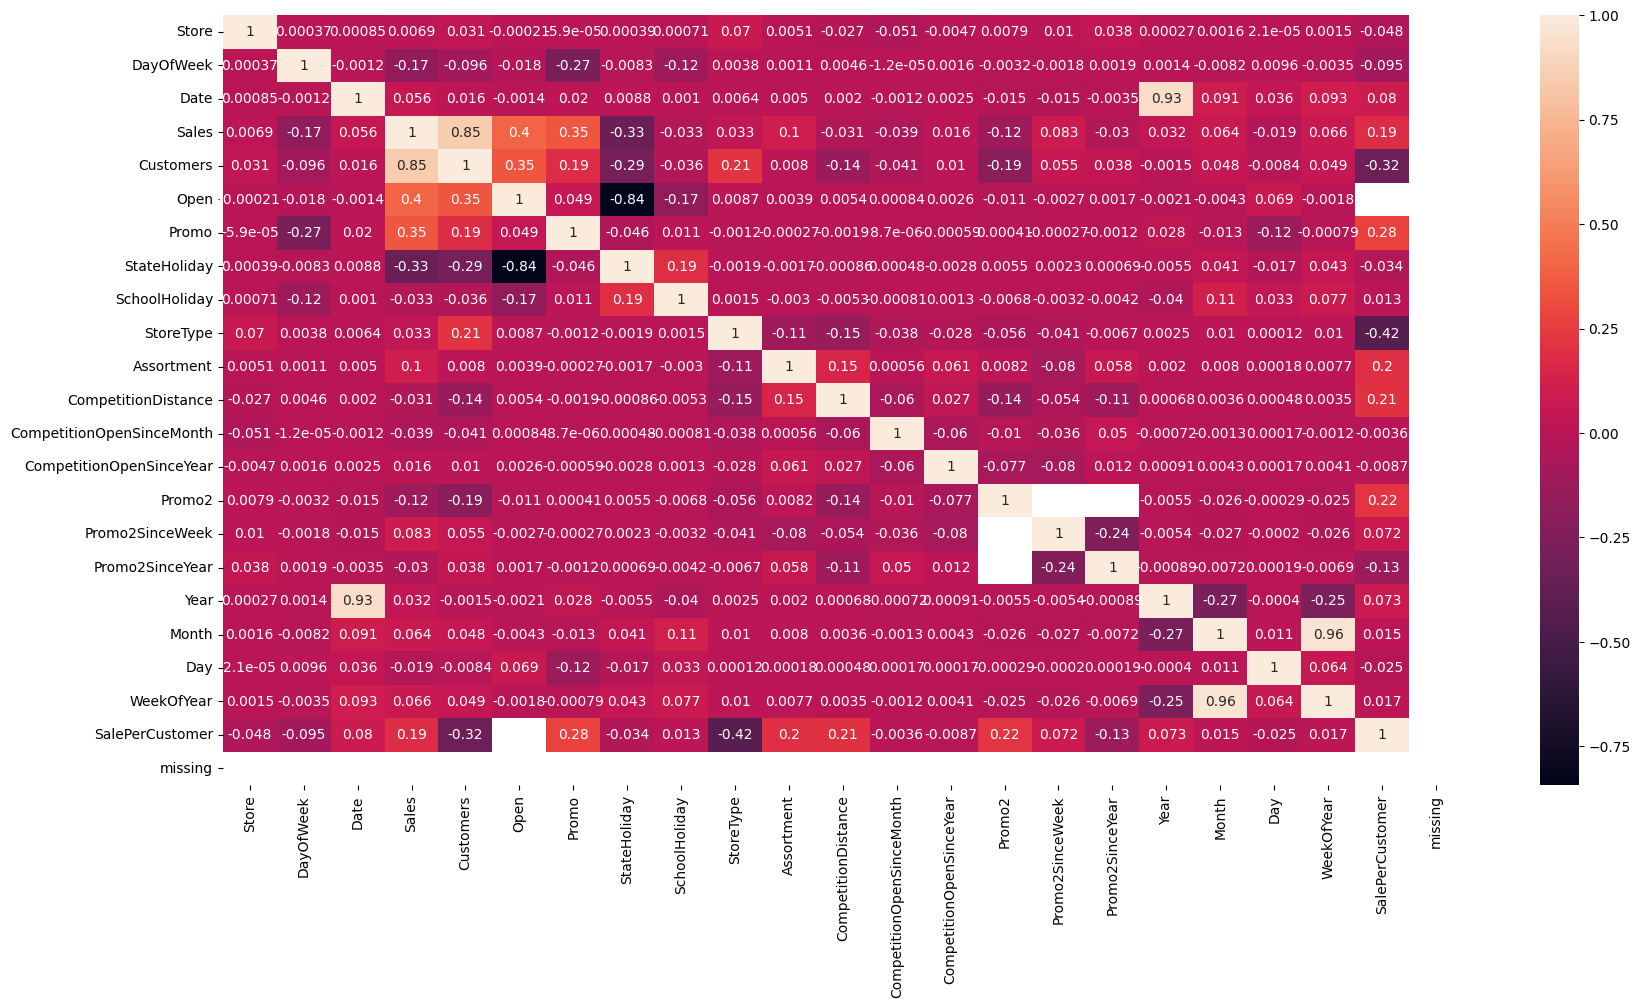

In [31]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(df_full.corr(), annot = True);

## Sales distribution

In [32]:
df_full['Sales'].describe()

count    877545.000000
mean       6692.740114
std        3321.262273
min           0.000000
25%        4672.000000
50%        6244.000000
75%        8257.000000
max       41551.000000
Name: Sales, dtype: float64

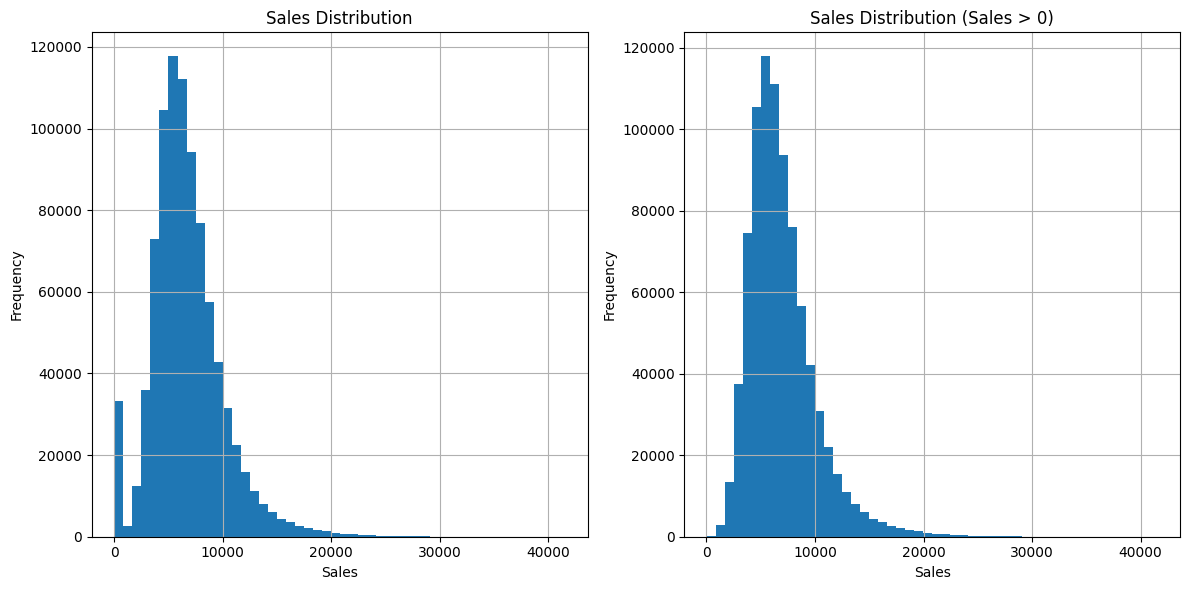

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df_full['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_full[df_full['Sales'] > 0]['Sales'].hist(bins=50)
plt.title('Sales Distribution (Sales > 0)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

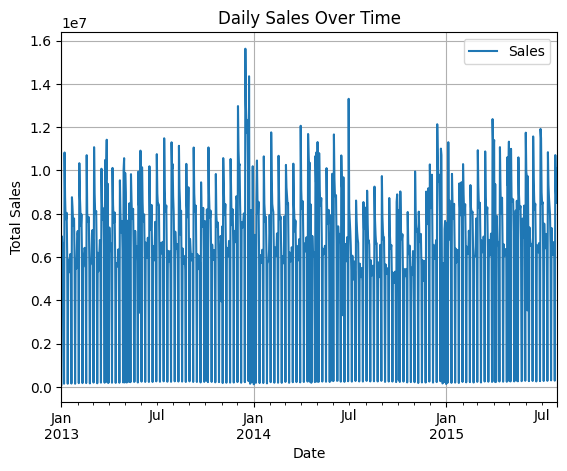

In [34]:
daily_sales = df_full.groupby('Date')['Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [36]:
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['WeekOfYear'] = daily_sales.index.isocalendar().week

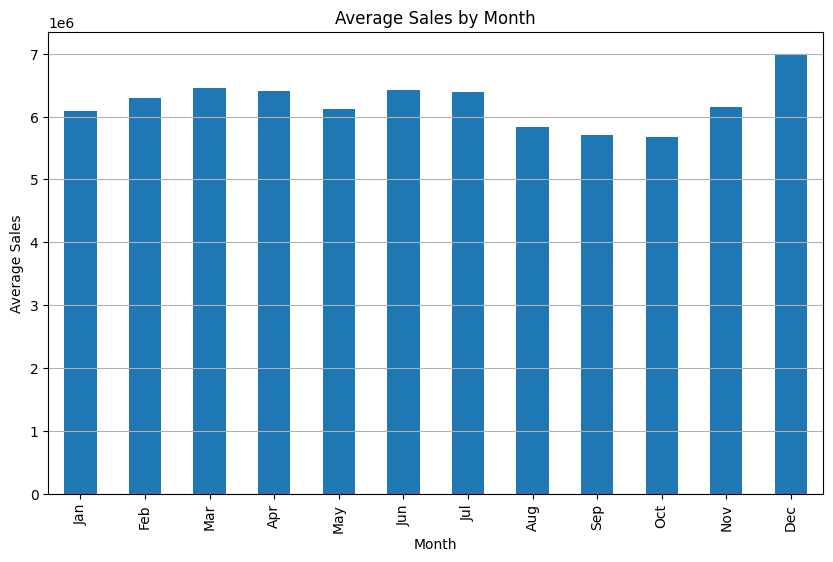

In [37]:
monthly_sales = daily_sales.groupby('Month')['Sales'].mean()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, axis='y')
plt.show()

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\USER\AppData\Local\Temp\ipykernel_25504\602274246.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


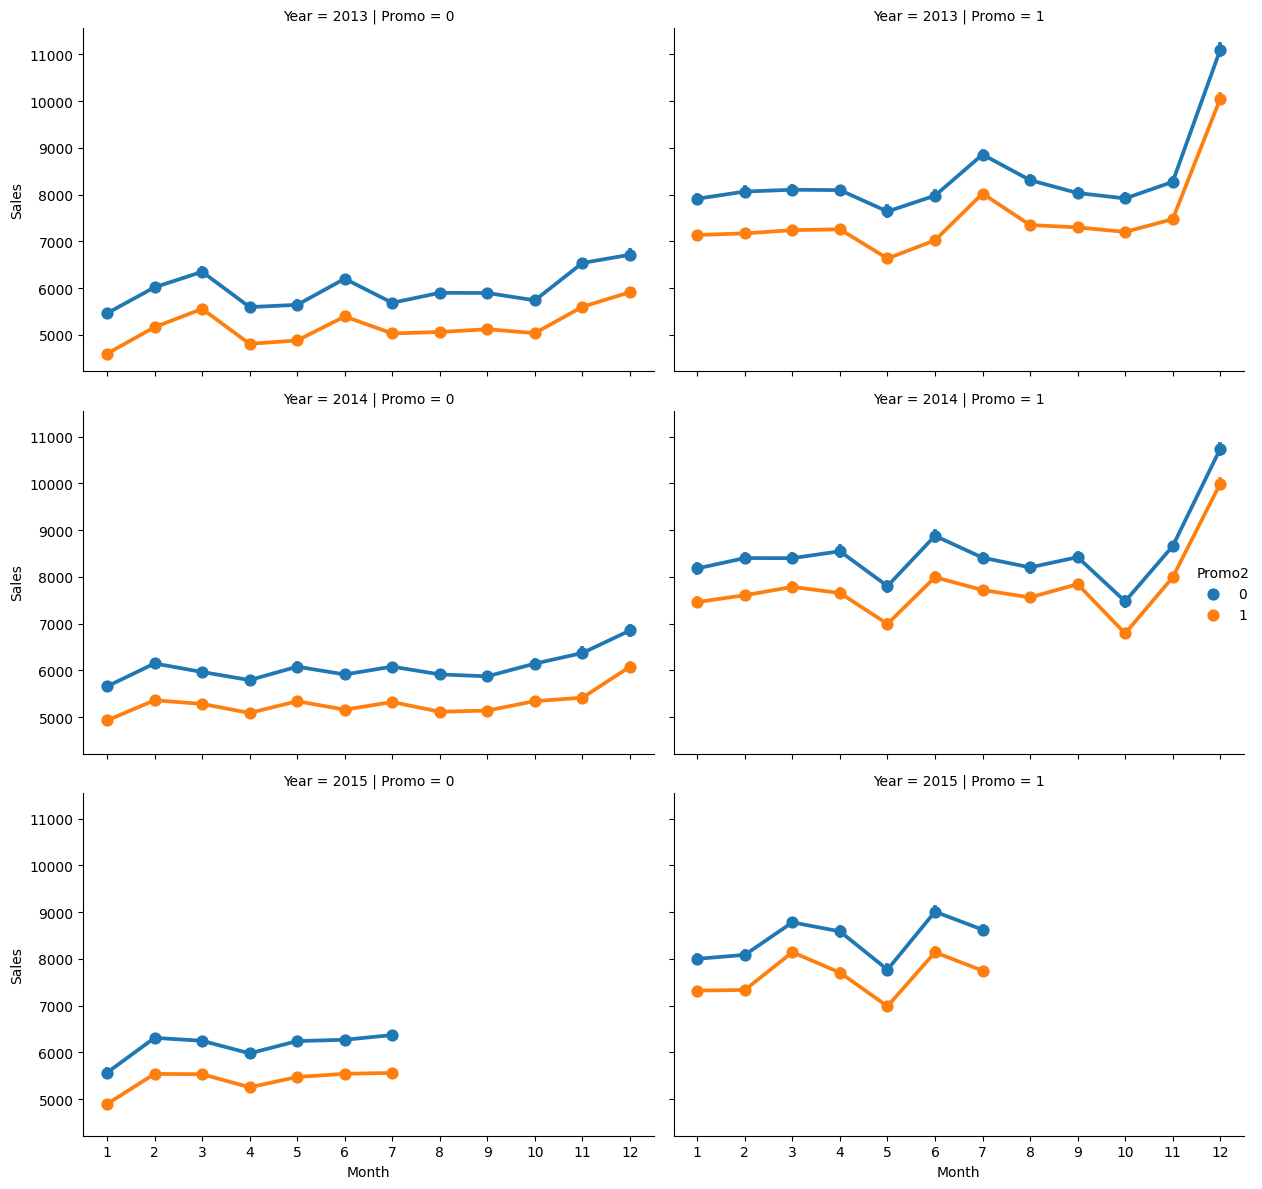

In [40]:
# Sales trend over the months
sns.catplot(
    data=df_full,
    x="Month",
    y="Sales",
    col="Promo",
    hue="Promo2",
    row="Year",
    kind="point",  # you can use "point" or "box" too
    height=4,
    aspect=1.5
)

plt.tight_layout()
plt.show()


We can see from the above trends that sales tend to spike in November and December. So, there is a seasonality factor present in the data.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


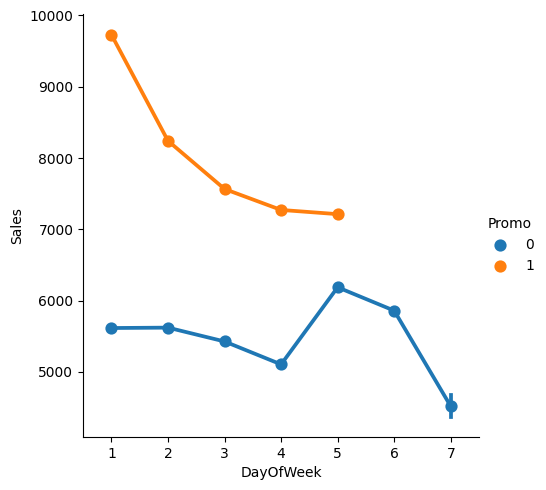

In [41]:
# Sales trend over days
sns.catplot(data = df_full, x = "DayOfWeek", y = "Sales", hue = "Promo", kind="point");

It make sense as the store is closed on sunday

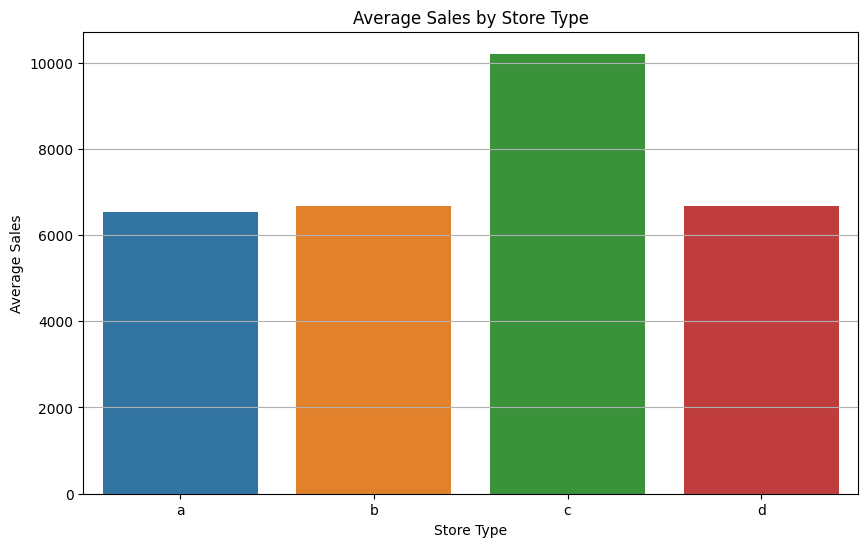

In [46]:
store_type_sales = df_full.groupby('StoreType')['Sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='StoreType', y='Sales', data=store_type_sales)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(ticks = [0,1,2,3],labels=['a','b','c','d'])
plt.grid(True, axis='y')
plt.show()

The heighest sales is of store type C

Choose The Store We will work on (Store 7)

In [105]:
df_7 = df_full[df_full["Store"] == 7].set_index('Date')
sales_7 = df_7['Sales']



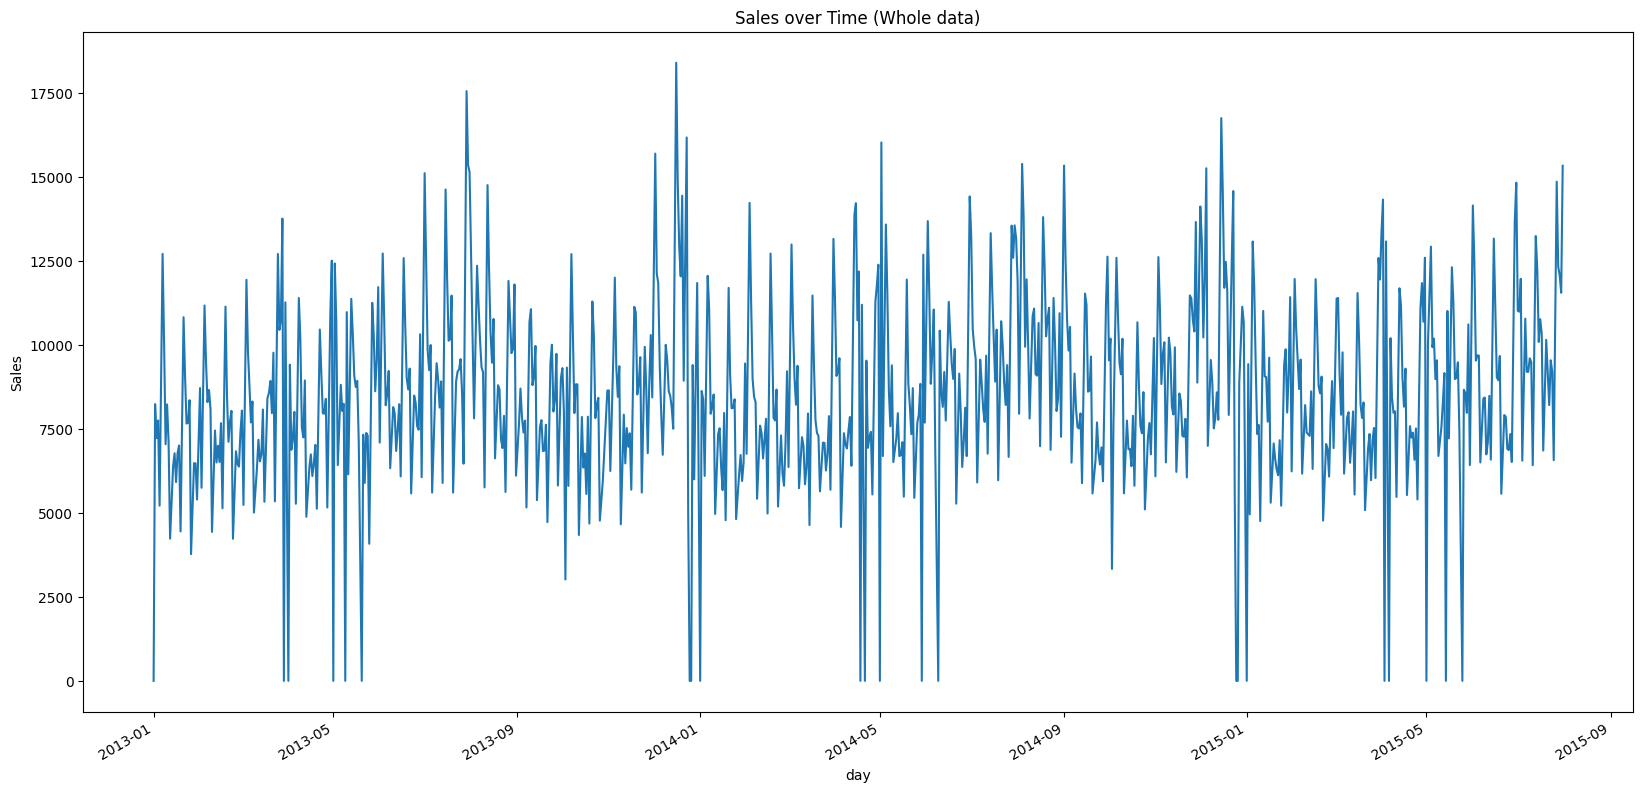

In [117]:
plt.figure(figsize=(20,10))
df_7["Sales"].plot()
# plt.ylim(bottom=0)
plt.xlabel('day')
plt.ylabel('Sales')
plt.title('Sales over Time (Whole data)')
plt.show()

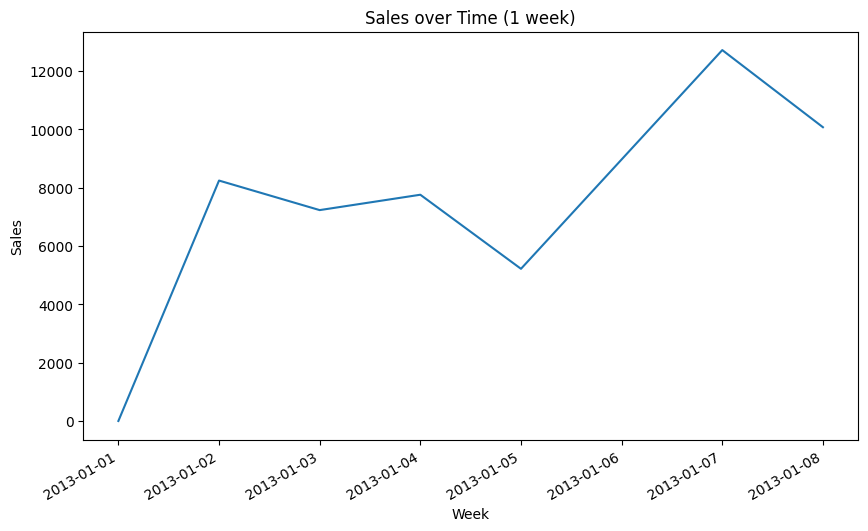

In [ ]:
plt.figure(figsize=(10, 6))
df_7['Sales'][:7].plot()
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Sales over Time (1 week)')
plt.show()

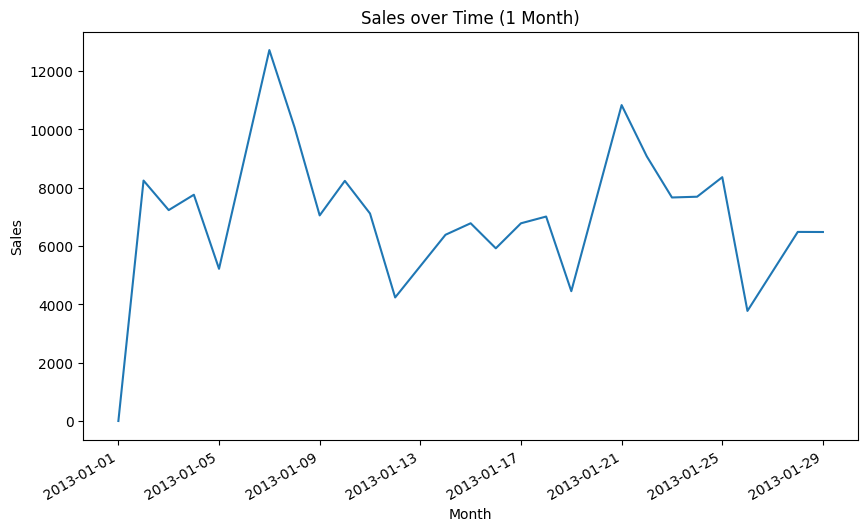

In [120]:
plt.figure(figsize=(10, 6))
df_7['Sales'][:25].plot()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales over Time (1 Month)')
plt.show()

In [121]:
df_7.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,SalePerCustomer,missing
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,7,2,0,0,0,0,1,1,1,3,...,2013.0,0,NaN,NaN,2013,1,1,1,NaN,False
2013-01-02,7,3,8244,955,1,0,0,1,1,3,...,2013.0,0,NaN,NaN,2013,1,2,1,8.632461,False
2013-01-03,7,4,7231,867,1,0,0,1,1,3,...,2013.0,0,NaN,NaN,2013,1,3,1,8.340254,False
2013-01-04,7,5,7758,870,1,0,0,1,1,3,...,2013.0,0,NaN,NaN,2013,1,4,1,8.917241,False
2013-01-05,7,6,5218,575,1,0,0,0,1,3,...,2013.0,0,NaN,NaN,2013,1,5,1,9.074783,False


In [128]:
def draw_seasonal_box_plot(df, col_name):
    # Draw Plot
    
    #plt.figure(figsize=(10, 10))  # Adjust the figsize as needed
    fig, axes = plt.subplots(1, 3,figsize=(15, 10))
    sns.boxplot(x='Year', y=col_name, data=df, ax=axes[0])
    #sns.boxplot(x='Quarter', y=col_name, data=df, ax=axes[1])
    sns.boxplot(x='Month', y=col_name, data=df, ax=axes[1])
    sns.boxplot(x='DayOfWeek', y=col_name, data=df, ax=axes[2])
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=10)
    #axes[1].set_title('Quarter-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[2].set_title('Weeknumber-wise Box Plot\n(The Seasonality)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

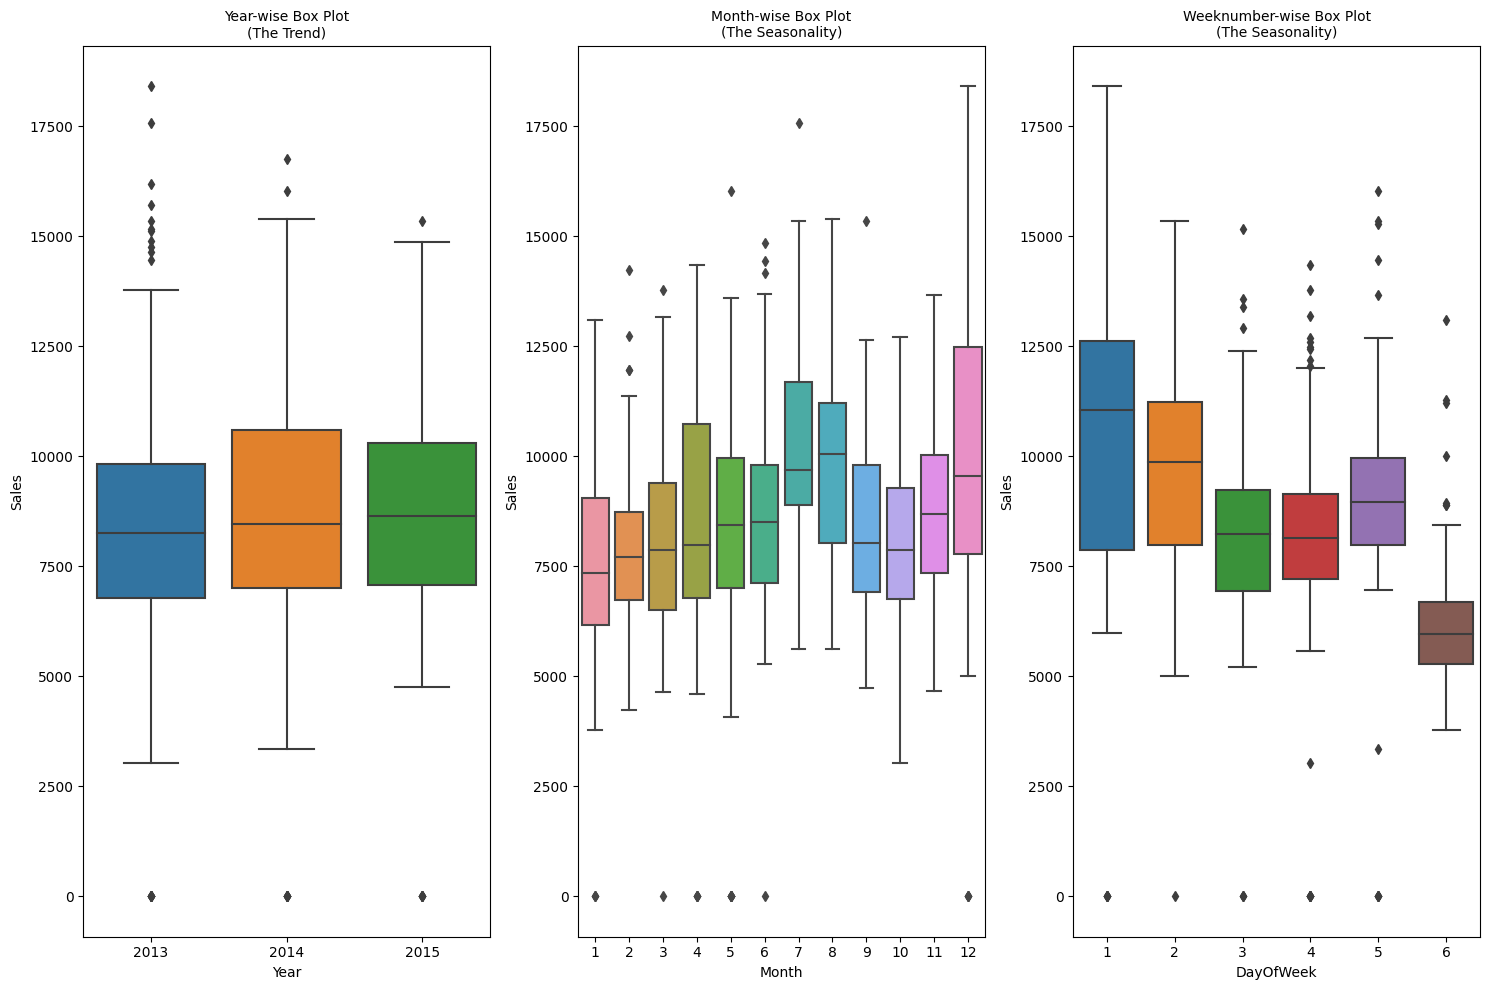

In [129]:
draw_seasonal_box_plot(df_7,"Sales")

- The peak of sales are in Nov and Dec (last two month because of holidays)
- 2014 has higher sales than the rest 
- Sales are better in Monday as the store is usually closed in Sunday

In [130]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 legend='full',palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')

    # move the legend outside of the main figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packa

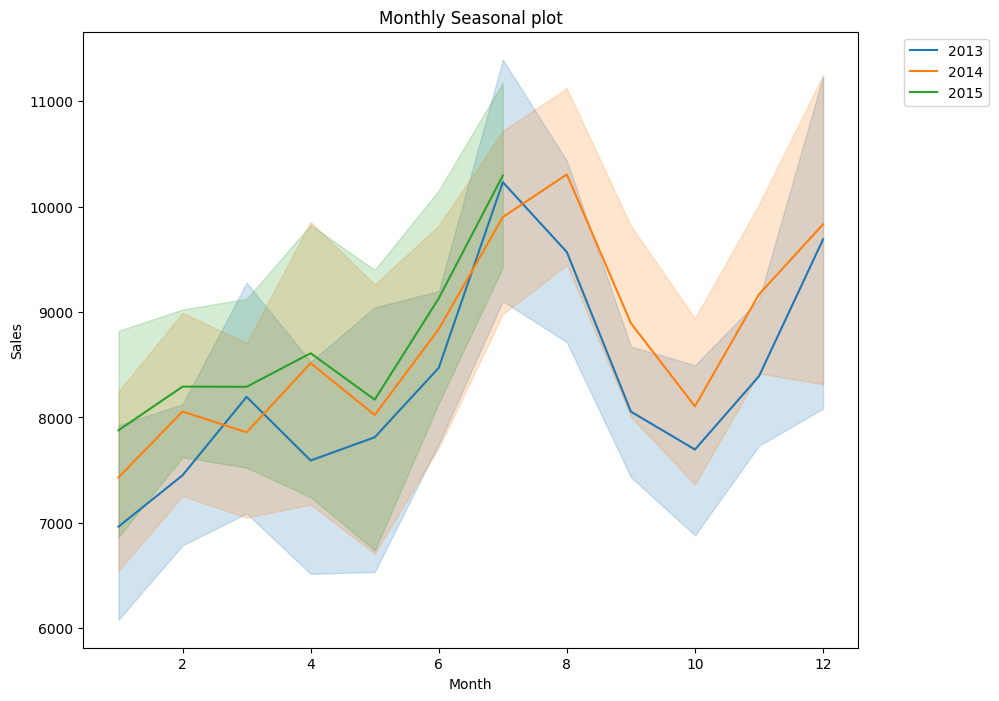

In [131]:
monthly_quarter_line_plot(df_7,"Month","Sales","Year",title="Monthly")

### Stationarity of Time Series 
In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time. 

There are 2 ways to test the stationarity of time series
1. Rolling Mean: Visualization
2. Dicky - Fuller test: Statistical test

1. Rolling Mean: A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

2. Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [106]:
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(df_7['Sales'])

Stationarity Test for Original Series:
ADF Statistic: -4.214526
p-value: 0.000623
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Result: The series is stationary


In [107]:
# Function to test the stationarity
def test_stationarity_rolling(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xticks(rotation= 45)
    plt.tight_layout()
    plt.show()
    
    



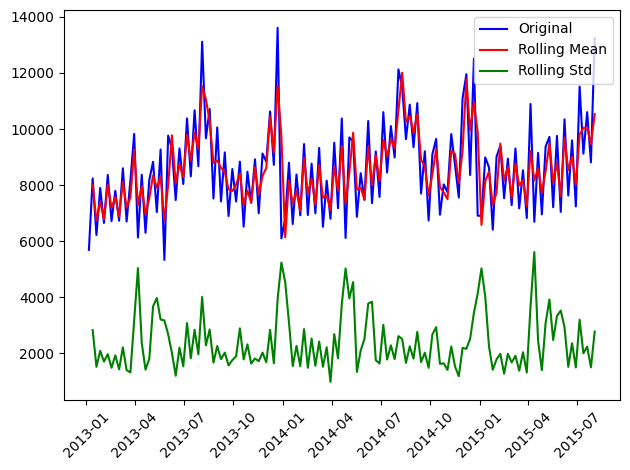

In [108]:
test_stationarity_rolling(sales_7)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary). 

In [133]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]
    
    percentage_error = np.abs((y_true_nz - y_pred_nz) / y_true_nz)
    return np.sqrt(np.mean(percentage_error ** 2))

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rmspe_val = rmspe(y_true, y_pred)
    
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSPE: {rmspe_val:.4f}")
    print("-" * 40)
    
    return mse, rmse, mae, rmspe_val

In [160]:
validation_days = 30
train_data = df_7.iloc[:-validation_days]
valid_data = df_7.iloc[-validation_days:]
y_true = valid_data['Sales'].values

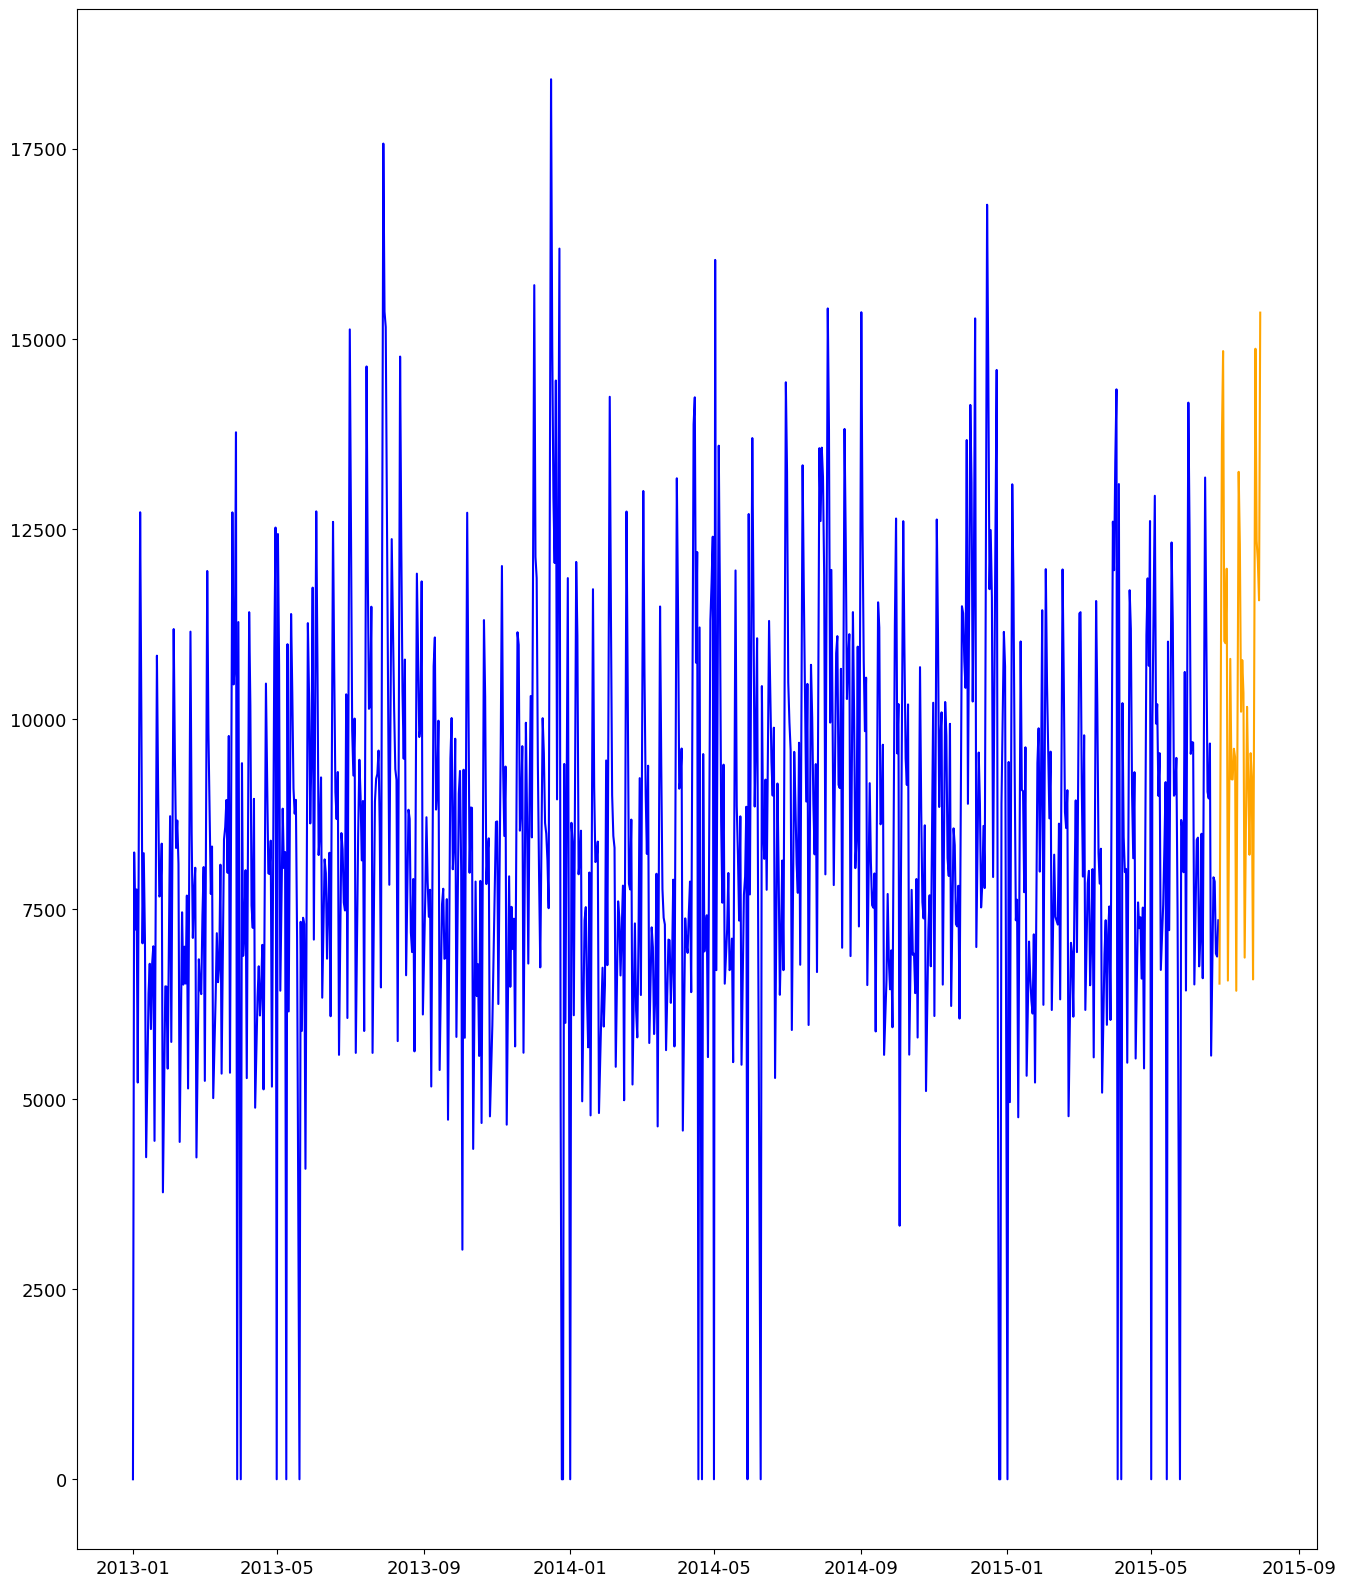

In [164]:
fig ,axes =plt.subplots(1,1)
axes.plot(train_data['Sales'], label='Train',color='blue')
axes.plot(valid_data['Sales'], label='Test',color='orange')
plt.show()

## Decompostion

In [134]:
def classical_decomposition(data,period_value=7,model_type="additive",plots=True):
    #We set extrapolate_trend to 'freq' which results in no NaN values in trend or resid components
    #Because smoothing using moving average method within the period value in case of two_sided=True
    #or at the begining only if we set two_sided=False
    result= seasonal_decompose(data,period=period_value, model=model_type,two_sided=False,
                                   extrapolate_trend='freq')
    
    trend = result.trend
    
    seasonal = result.seasonal
    residuals = result.resid
    
    if plots:
        resid_var = np.var(residuals.values)
        trend_resid_var = np.var(residuals.values+trend.values)
        seasonal_resid_var = np.var(residuals.values+seasonal.values)
        trend_strength = max(0,1-(resid_var/trend_resid_var))
        seasonal_strength = max(0,1-(resid_var/seasonal_resid_var))
        
        print(f"The strength of the trend is: {trend_strength} \n And the strength of Seasonality is: {seasonal_strength}")
        
        fig,axes = plt.subplots(4, 1, sharex=True, sharey=False)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        axes[0].plot(data, label='Original')
        axes[0].legend(loc='upper left')

        axes[1].plot(trend, label='Trend')
        axes[1].legend(loc='upper left')

        axes[2].plot(seasonal, label='Seasonality')
        axes[2].legend(loc='upper left')

        axes[3].plot(residuals, label='Residuals')
        axes[3].legend(loc='upper left')
    
    return trend,seasonal,residuals


- Multiplicative won't work as our sales have zero values

The strength of the trend is: 0.03651694480186385 
 And the strength of Seasonality is: 0.43036014252781896


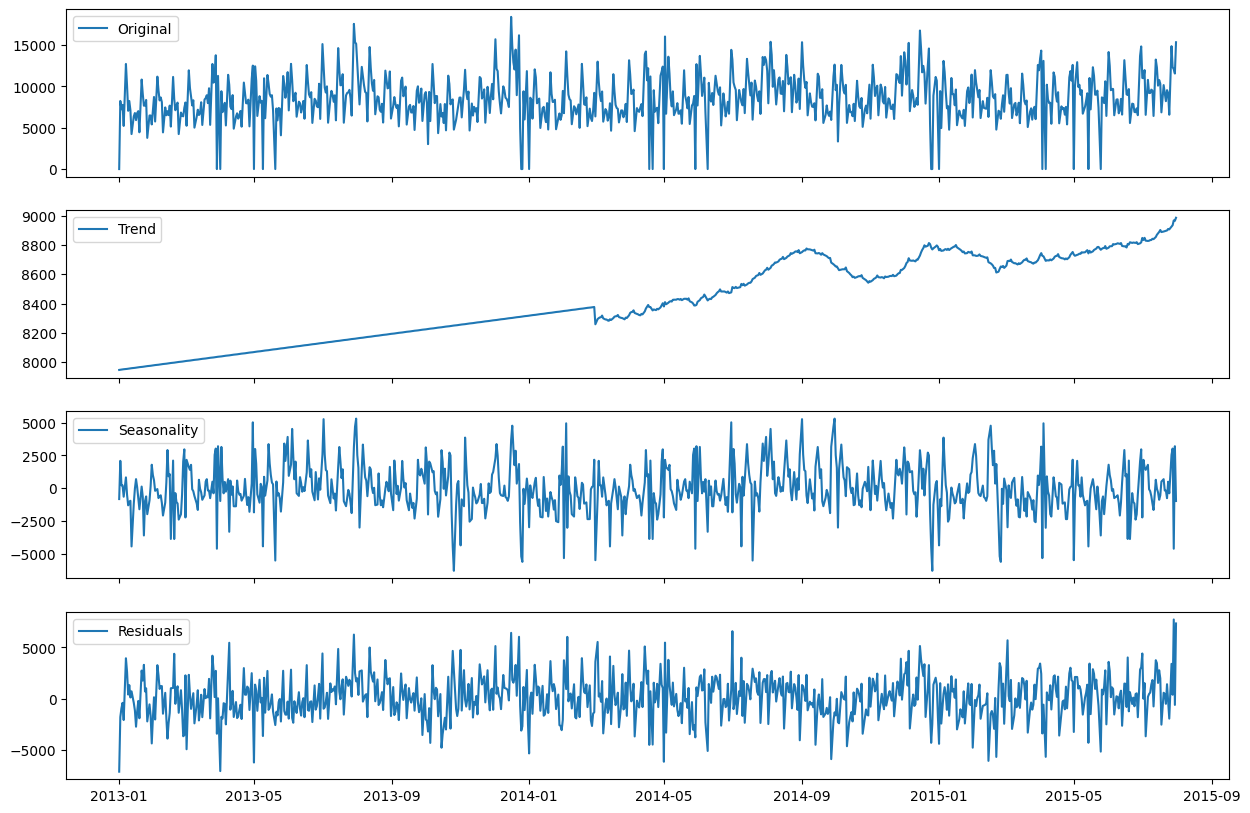

In [141]:
trend_add, seasonal_add, resid_add = classical_decomposition(df_7['Sales'],period_value=365,
                                                            model_type="additive",plots=True)

In [144]:
def STL_decomposition(data,n_p=7,robustness=True,n_t=14,n_L=9,s_d=0,t_d=0,lp_d=0,model_type="additive",plots=True):
    if model_type =="multiplicative":
        data_used = np.log(data)
    else:
        data_used = data
    stl = STL(data_used,robust = robustness,
              period=n_p,trend=n_t,low_pass=n_L,
              seasonal_deg=s_d,trend_deg=t_d,low_pass_deg=lp_d,
             )
    result = stl.fit()
    if model_type =="multiplicative":
        trend = np.exp(result.trend)
        seasonal = np.exp(result.seasonal)
        residuals = np.exp(result.resid)
    else:
        trend = result.trend
        seasonal = result.seasonal
        residuals = result.resid

    if plots:
        resid_var = np.var(residuals.values)
        trend_resid_var = np.var(residuals.values+trend.values)
        seasonal_resid_var = np.var(residuals.values+seasonal.values)
        trend_strength = max(0,1-(resid_var/trend_resid_var))
        seasonal_strength = max(0,1-(resid_var/seasonal_resid_var))
        
        print(f"The strength of the trend is: {trend_strength} \n And the strength of Seasonality is: {seasonal_strength}")
        
        fig,axes = plt.subplots(4, 1, sharex=True, sharey=False)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        axes[0].plot(data, label='Original')
        axes[0].legend(loc='upper left')

        axes[1].plot(trend, label='Trend')
        axes[1].legend(loc='upper left')

        axes[2].plot(seasonal, label='Seasonality')
        axes[2].legend(loc='upper left')

        axes[3].plot(residuals, label='Residuals')
        axes[3].legend(loc='upper left')
    
    return trend,seasonal,residuals


The strength of the trend is: 0.9903871628448342 
 And the strength of Seasonality is: 0.9998638455866289


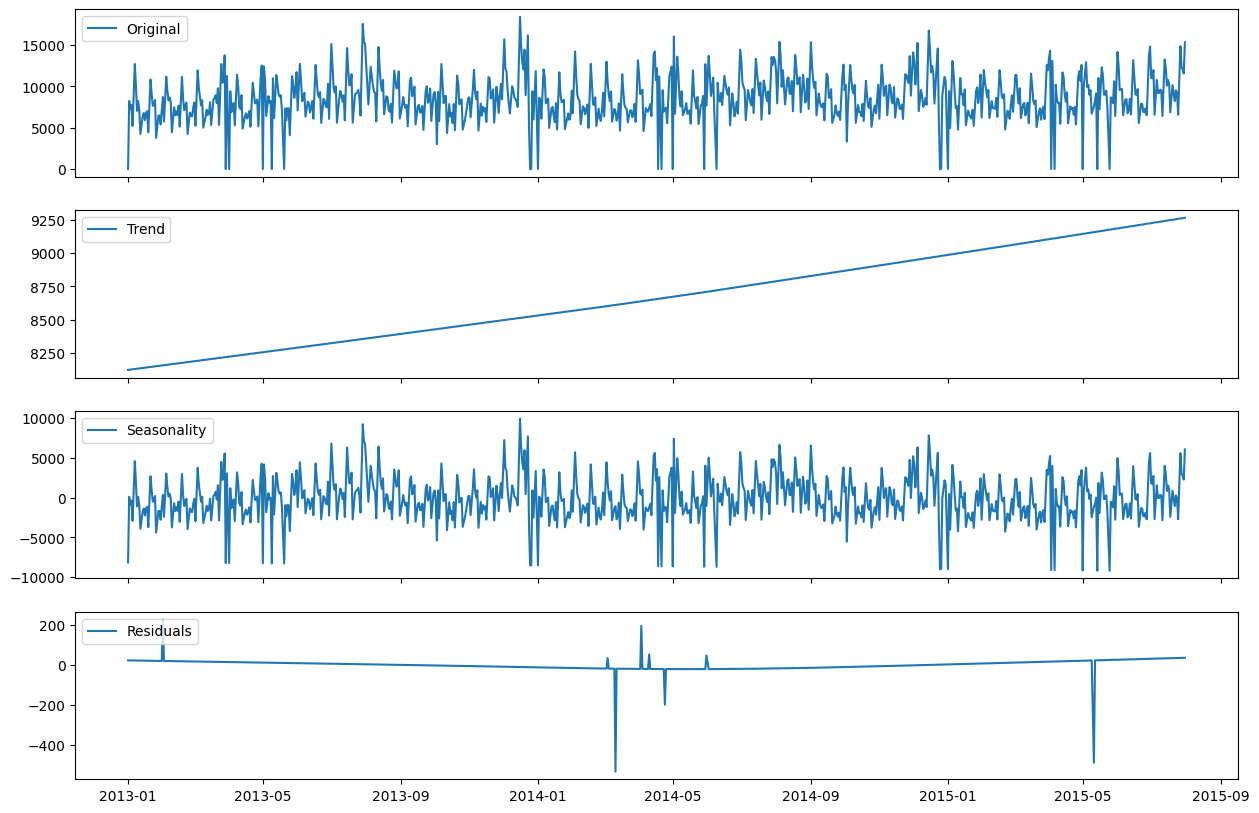

In [148]:
trend_stl,seasonal_stl,residuals_stl = STL_decomposition(df_7['Sales'],
                                                         n_p=365,robustness=True,n_t=(365*2)+1,n_L=367,
                                                         s_d=1,t_d=1,lp_d=1,model_type="additive",plots=True)


In [241]:
# check if res is stationary
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna(),regression='ctt')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(residuals_stl)

Stationarity Test for Original Series:
ADF Statistic: -28.074638
p-value: 0.000000
Critical Values:
	1%: -4.386
	5%: -3.840
	10%: -3.558
Result: The series is stationary


In [157]:
mstl = MSTL(df_7["Sales"], periods=(7, 30,365), stl_kwargs={"seasonal_deg": 1})
res = mstl.fit()

In [245]:
print(type(res.resid))

<class 'pandas.core.series.Series'>


In [247]:
# check if res is stationary
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna(),regression='n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(res.resid)

Stationarity Test for Original Series:
ADF Statistic: -6.677266
p-value: 0.000000
Critical Values:
	1%: -2.569
	5%: -1.941
	10%: -1.616
Result: The series is stationary


C:\Users\USER\AppData\Local\Temp\ipykernel_25504\2060783969.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


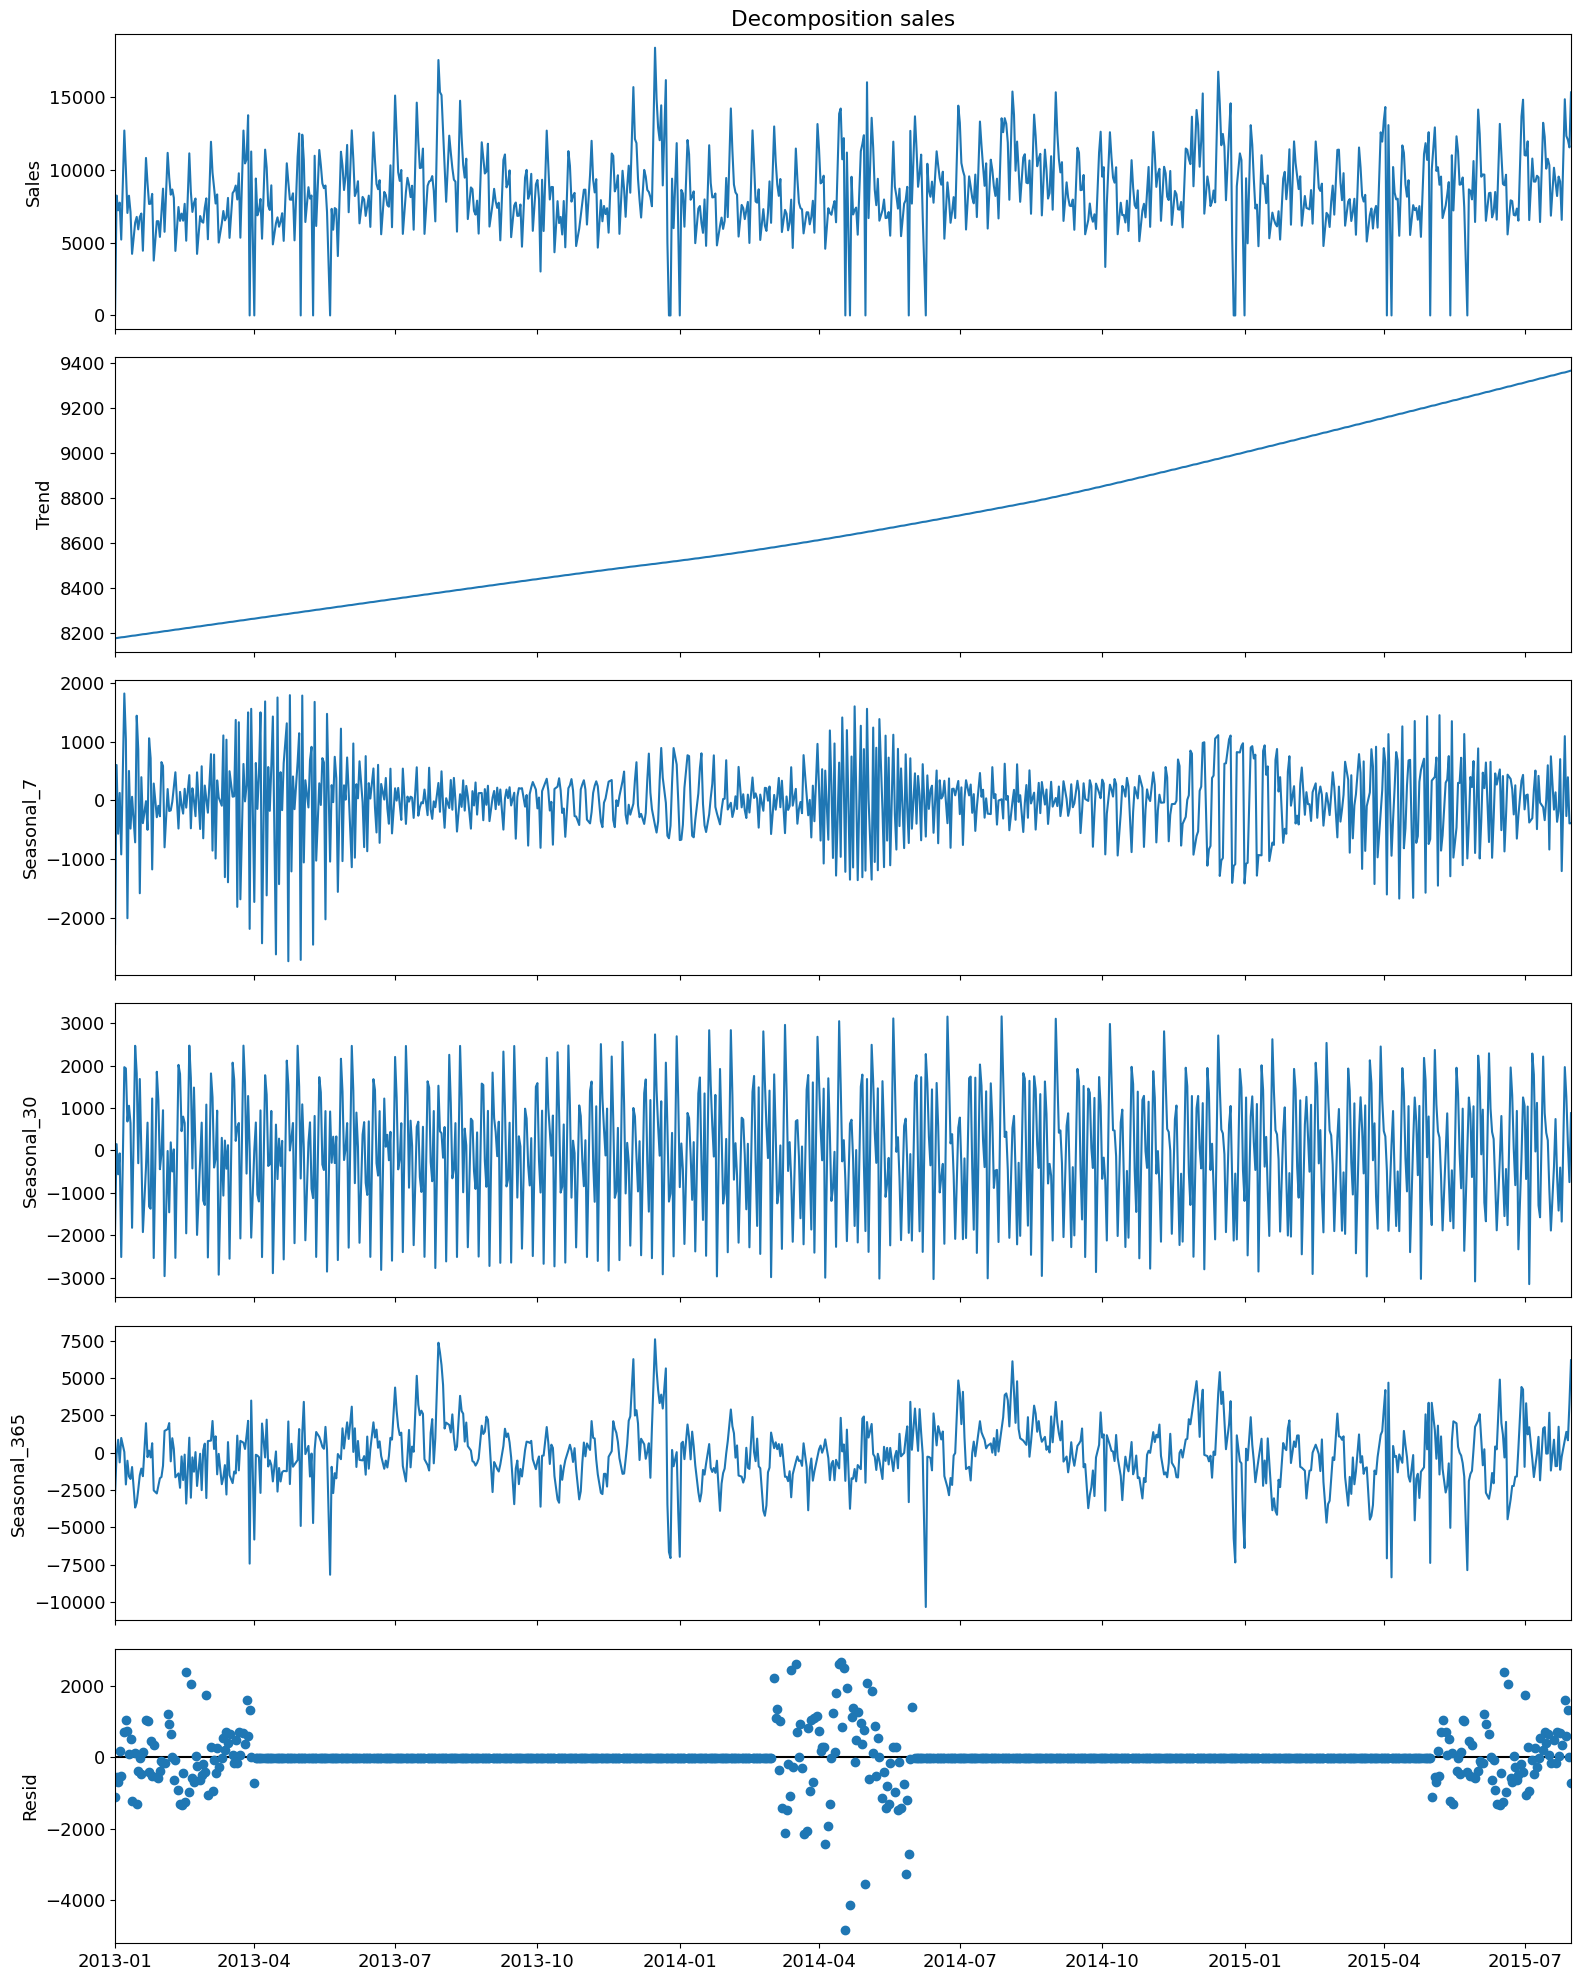

In [158]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

axs[0].set_ylabel("Sales")
axs[0].set_title("Decomposition sales")

plt.tight_layout()

# 2. Simple Forecasting

In [193]:
validation_days = 30
train_data = df_7.iloc[:-validation_days]
valid_data = df_7.iloc[-validation_days:]
y_true = valid_data['Sales'].values


In [230]:
def average_method(train_data,test_data):
    ## Average method 
    average_prediction = [np.mean(train_data)]*len(test_data)
    average_pred = pd.DataFrame(average_prediction)
    average_pred.index = test_data.index
    return average_pred

def naive_method(train_data,test_data):
    ##Naive method
    naiive_prediction = [train_data.iloc[-1]]*len(test_data)
    naiive_pred = pd.DataFrame(naiive_prediction)
    naiive_pred.index = test_data.index
    return naiive_pred

def seasonal_naive(train_data,test_data):
    ##SEasonal_NAive
    #print(test_data.index)
    dates = (test_data.index - np.timedelta64(52, 'W')).values.astype('datetime64[D]')
    dates_added = dates[2:] +np.timedelta64(1,'W')
    dates = np.concatenate((dates[:2],dates_added))
    #print(train_data.index)
    #print(dates)
    #print(train_data.index.isin(dates))
    seasonal_naive_prediction = train_data[train_data.index.isin(dates)].values # seasonal naive prediction
    #print(seasonal_naive)
    #seasonal_naive = test_data.copy()
    seasonal_naive = pd.DataFrame(seasonal_naive_prediction).set_index(test_data.index)
    return seasonal_naive

def drift_method(train_data,test_data):
    # Get the slope
    y_t = train_data[len(train_data)-1]
    #print(y_t)
    #print(train_data[1])
    m = (y_t - train_data[1]) / len(train_data)
    #print(m)
    #y_hat_drift = test.copy().drop('sales', axis=1)
    h = np.linspace(0,len(test_data)-1, len(test_data))
    #print(h)
    drift_prediction = y_t + m * h
    drift_pred = pd.DataFrame(drift_prediction).set_index(test_data.index)
    return drift_pred

In [231]:
average_pred = average_method(train_data['Sales'],valid_data['Sales'])
naiive_pred = naive_method(train_data['Sales'],valid_data['Sales'])
seasonal_naive_pred = seasonal_naive(train_data['Sales'],valid_data['Sales'])
drift_pred = drift_method(train_data['Sales'],valid_data['Sales'])

C:\Users\USER\AppData\Local\Temp\ipykernel_25504\2684240575.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_t = train_data[len(train_data)-1]
C:\Users\USER\AppData\Local\Temp\ipykernel_25504\2684240575.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = (y_t - train_data[1]) / len(train_data)


In [232]:
naive_metrics = evaluate_model(y_true, naiive_pred, "Naive Method")
ave_metrics = evaluate_model(y_true, average_pred, "average Method")
seasonal_naive_metrics = evaluate_model(y_true, seasonal_naive_pred, "Seasonal Naive Method")
drift_metrics = evaluate_model(y_true, drift_pred, "Drift Method")

Naive Method Results:
MSE: 15619635.63
RMSE: 3952.17
MAE: 3336.30
RMSPE: 0.3169
----------------------------------------
average Method Results:
MSE: 9841583.81
RMSE: 3137.13
MAE: 2586.80
RMSPE: 0.2603
----------------------------------------
Seasonal Naive Method Results:
MSE: 6874863.47
RMSE: 2622.00
MAE: 2106.47
RMSPE: 0.3848
----------------------------------------
Drift Method Results:
MSE: 15728118.52
RMSE: 3965.87
MAE: 3348.34
RMSPE: 0.3179
----------------------------------------


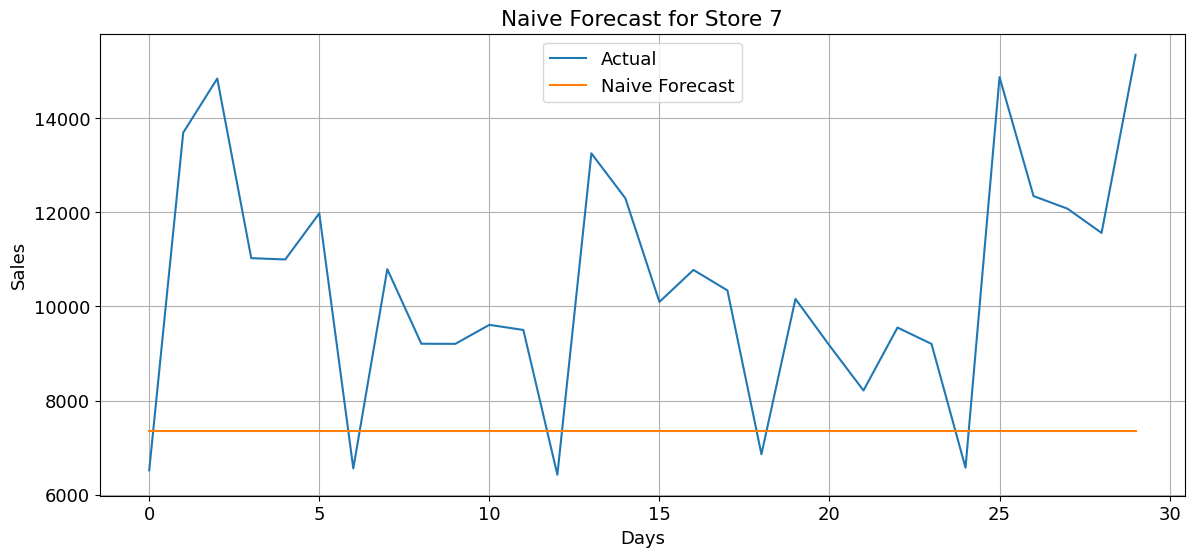

In [233]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(naiive_pred)), naiive_pred, label='Naive Forecast')
plt.title(f'Naive Forecast for Store {7}')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

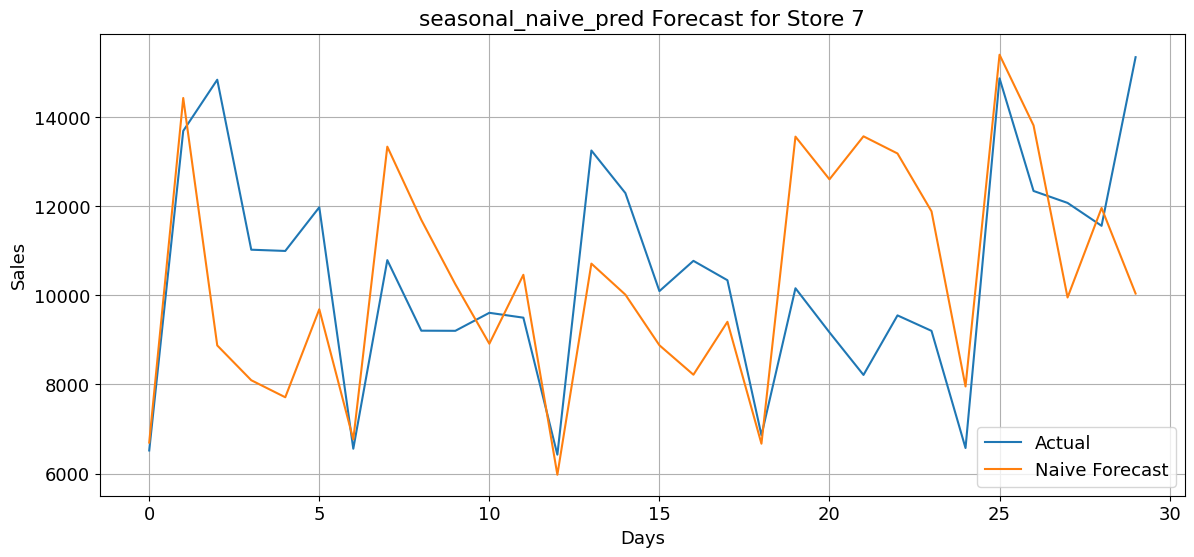

In [235]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(seasonal_naive_pred)), seasonal_naive_pred, label='Naive Forecast')
plt.title(f'seasonal_naive_pred Forecast for Store {7}')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# 3. ETL Modles

# 4. Arima Models

# 5. Prophet

# 6. ML Models

# Bouns DL : LSTM model

# Bouns Foundation Model: TimesFM from Google

by using `zero-shot prediction`
we just use it out of the box for making predictions on new, unseen data.

the idea is to patchify a time series into smaller pieces which serves as 'tokens'